In [22]:
import sys
import numpy as np
import math
import random
import matplotlib
import pandas as pd
from collections import namedtuple
from matplotlib import pyplot as plt

import gym
import gym_maze

import pdb

def simulate():
    # stats
    EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])
    stats = EpisodeStats(episode_lengths = np.zeros(NUM_EPISODES), episode_rewards = np.zeros(NUM_EPISODES))    
    # Instantiating the learning related parameters
    learning_rate = get_learning_rate(0)
    explore_rate = get_explore_rate(0)
    discount_factor = 0.99

    num_streaks = 0

    # Render tha maze
    env.render()

    for episode in range(NUM_EPISODES):

        # Reset the environment
        obv = env.reset()

        # the initial state
        state_0 = state_to_bucket(obv)
        total_reward = 0

        for t in range(MAX_T):

            # Select an action
            action = select_action(state_0, explore_rate)

            # execute the action
            obv, reward, done, _ = env.step(action)

            # Observe the result
            state = state_to_bucket(obv)
            total_reward += reward

            # Update the Q based on the result
            q_table_0 = q_table.copy()
            best_q = np.amax(q_table_0[state])
            best_q_state0 = np.amax(q_table_0[state_0])
            best_a_state0 = np.argmax(q_table_0[state_0])

            td_error = reward + discount_factor * (best_q) - q_table[state_0 + (action,)]
            
            q_table[state_0 + (action,)] += learning_rate * td_error
            
            td_errors.append(td_error)
            eves.append(np.amax(q_table[state_0]) - best_q_state0)
            value_ivs.append(q_table[state_0][best_a_state0] - best_q_state0)
            policy_ivs.append(np.amax(q_table[state_0]) - best_q_state0 - (q_table[state_0][best_a_state0] - best_q_state0))
            # Setting up for the next iteration
            state_0 = state

            # Print data
            if DEBUG_MODE == 2:
                print("\nEpisode = %d" % episode)
                print("t = %d" % t)
                print("Action: %d" % action)
                print("State: %s" % str(state))
                print("Reward: %f" % reward)
                print("Best Q: %f" % best_q)
                print("Explore rate: %f" % explore_rate)
                print("Learning rate: %f" % learning_rate)
                print("Streaks: %d" % num_streaks)
                print("")

            elif DEBUG_MODE == 1:
                if done or t >= MAX_T - 1:
                    print("\nEpisode = %d" % episode)
                    print("t = %d" % t)
                    print("Explore rate: %f" % explore_rate)
                    print("Learning rate: %f" % learning_rate)
                    print("Streaks: %d" % num_streaks)
                    print("Total reward: %f" % total_reward)
                    print("")

            # Render tha maze
            if RENDER_MAZE:
                env.render()

            if env.is_game_over():
                sys.exit()

            if done:
                print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                      % (episode, t, total_reward, num_streaks))

                if t <= SOLVED_T:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= MAX_T - 1:
                print("Episode %d timed out at %d with total reward = %f."
                      % (episode, t, total_reward))
        
        stats.episode_lengths[episode] = t
        stats.episode_rewards[episode] = total_reward

        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > STREAK_TO_END:
            break

        # Update parameters
        explore_rate = get_explore_rate(episode)
        learning_rate = get_learning_rate(episode)
    return(stats)


def select_action(state, explore_rate):
    # Select a random action (when epsilon probability and q_value are the same in that state)
    if random.random() < explore_rate or np.all(np.isclose(q_table[1], q_table[1][0])):
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action


def get_explore_rate(t):
    return max(MIN_EXPLORE_RATE, min(1, 1.0 - math.log10((t+1)/DECAY_FACTOR)))


def get_learning_rate(t):
    return max(MIN_LEARNING_RATE, min(1, 1.0 - math.log10((t+1)/DECAY_FACTOR)))


def state_to_bucket(state):
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= STATE_BOUNDS[i][0]:
            bucket_index = 0
        elif state[i] >= STATE_BOUNDS[i][1]:
            bucket_index = NUM_BUCKETS[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]
            offset = (NUM_BUCKETS[i]-1)*STATE_BOUNDS[i][0]/bound_width
            scaling = (NUM_BUCKETS[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)


if __name__ == "__main__":

    # Initialize the "maze" environment
    env = gym.make("maze-sample-5x5-v0").unwrapped

    '''
    Defining the environment related constants
    '''
    # Number of discrete states (bucket) per state dimension
    MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
    NUM_BUCKETS = MAZE_SIZE  # one bucket per grid

    # Number of discrete actions
    NUM_ACTIONS = env.action_space.n  # ["N", "S", "E", "W"]
    # Bounds for each discrete state
    STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))

    '''
    Learning related constants
    '''
    MIN_EXPLORE_RATE = 0.001
    MIN_LEARNING_RATE = 1
    DECAY_FACTOR = np.prod(MAZE_SIZE, dtype=float) / 10.0

    '''
    Defining the simulation related constants
    '''
    NUM_EPISODES = 50
    MAX_T = np.prod(MAZE_SIZE, dtype=int) * 100
    STREAK_TO_END = 50
    SOLVED_T = np.prod(MAZE_SIZE, dtype=int)
    DEBUG_MODE = 0
    RENDER_MAZE = True
    ENABLE_RECORDING = True

    '''
    Creating a Q-Table for each state-action pair
    '''
    q_table = np.random.rand(NUM_BUCKETS[0], NUM_BUCKETS[1], NUM_ACTIONS)

    '''
    Begin simulation
    '''
    recording_folder = "/tmp/maze_q_learning"
    
    # Recordings
    policy_ivs = []
    value_ivs = []
    eves = []
    td_errors = []

    stats_recorded = simulate()
    env.close()

Episode 0 finished after 309.000000 time steps with total reward = -0.236000 (streak 0).
Episode 1 finished after 1062.000000 time steps with total reward = -3.248000 (streak 0).
Episode 2 finished after 575.000000 time steps with total reward = -1.300000 (streak 0).
Episode 3 finished after 127.000000 time steps with total reward = 0.492000 (streak 0).
Episode 4 finished after 204.000000 time steps with total reward = 0.184000 (streak 0).
Episode 5 finished after 111.000000 time steps with total reward = 0.556000 (streak 0).
Episode 6 finished after 130.000000 time steps with total reward = 0.480000 (streak 0).
Episode 7 finished after 86.000000 time steps with total reward = 0.656000 (streak 0).
Episode 8 finished after 30.000000 time steps with total reward = 0.880000 (streak 0).
Episode 9 finished after 24.000000 time steps with total reward = 0.904000 (streak 0).
Episode 10 finished after 24.000000 time steps with total reward = 0.904000 (streak 1).
Episode 11 finished after 43.00

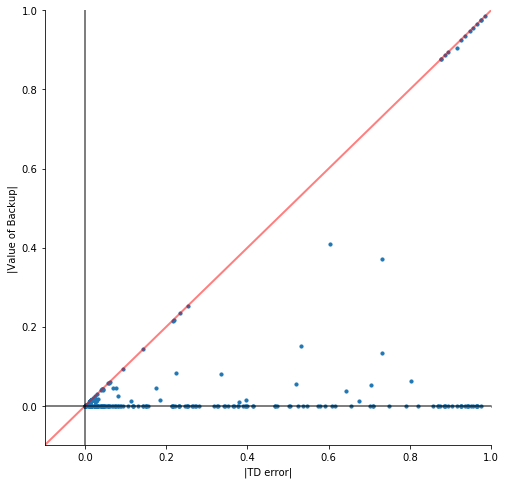

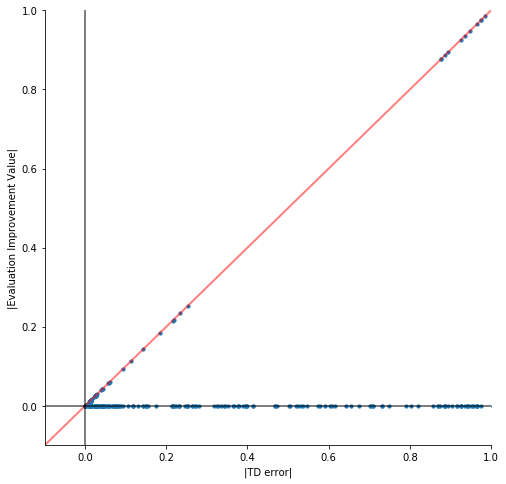

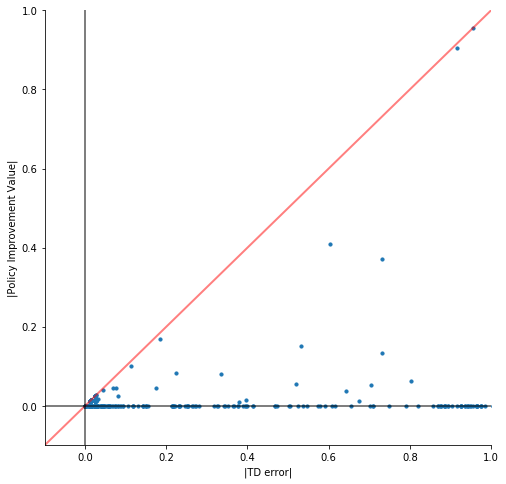

In [40]:
plt.figure()
plotlim = 1
plt.scatter(np.abs(td_errors), np.abs(eves),s=10)
plt.xlabel('|TD error|')
plt.ylabel('|Value of Backup|')
plt.xlim(-0.1,plotlim)
plt.ylim(-0.1,plotlim)
plt.plot([-plotlim,plotlim], [-plotlim,plotlim], color = 'red', linewidth = 2, alpha = 0.5)
plt.plot([-1,1], [0,0], color = 'black', linewidth = 2, alpha = 0.5)
plt.plot([0,0], [-1,1], color = 'black', linewidth = 2, alpha = 0.5)
fig = plt.gcf()
[ax1] = fig.axes
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.set_size_inches(8,8)
fig.savefig('figure/q_maze_evb_bound.png', dpi=100)
fig.savefig('figure/q_maze_evb_bound.pdf', dpi=100)
plt.show()

plt.scatter(np.abs(td_errors), np.abs(value_ivs),s=10)
plt.xlabel('|TD error|')
plt.ylabel('|Evaluation Improvement Value|')
plt.xlim(-0.1,plotlim)
plt.ylim(-0.1,plotlim)
plt.plot([-plotlim,plotlim], [-plotlim,plotlim], color = 'red', linewidth = 2, alpha = 0.5)
plt.plot([-1,1], [0,0], color = 'black', linewidth = 2, alpha = 0.5)
plt.plot([0,0], [-1,1], color = 'black', linewidth = 2, alpha = 0.5)
fig = plt.gcf()
[ax1] = fig.axes
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.set_size_inches(8,8)
fig.savefig('figure/q_maze_eiv_bound.png', dpi=100)
fig.savefig('figure/q_maze_eiv_bound.pdf', dpi=100)
plt.show()

plt.scatter(np.abs(td_errors), np.abs(policy_ivs),s=10)
plt.xlabel('|TD error|')
plt.ylabel('|Policy Improvement Value|')
plt.xlim(-0.1,plotlim)
plt.ylim(-0.1,plotlim)
plt.plot([-plotlim,plotlim], [-plotlim,plotlim], color = 'red', linewidth = 2, alpha = 0.5)
plt.plot([-1,1], [0,0], color = 'black', linewidth = 2, alpha = 0.5)
plt.plot([0,0], [-1,1], color = 'black', linewidth = 2, alpha = 0.5)
fig = plt.gcf()
[ax1] = fig.axes
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
fig.set_size_inches(8,8)
fig.savefig('figure/q_maze_piv_bound.png', dpi=100)
fig.savefig('figure/q_maze_piv_bound.pdf', dpi=100)

plt.show()


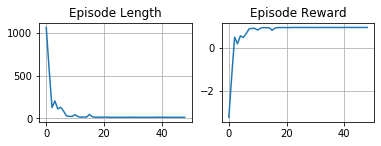

In [24]:
# plot with various axes scales
plt.figure()

# linear
plt.subplot(221)
plt.plot(stats_recorded.episode_lengths[1:100])
plt.title('Episode Length')

plt.grid(True)


# log
plt.subplot(222)
plt.plot(stats_recorded.episode_rewards[1:100])
plt.title('Episode Reward')
plt.grid(True)
# plt.savefig('maze q learning.png', dpi = 800)
plt.show()


In [46]:
import pickle
# save file to pickle
result_data = {"td": td_errors, "evb": eves, "piv": policy_ivs, "eiv": value_ivs,  "episode_rewards":stats_recorded.episode_rewards, "episode_lengths":stats_recorded.episode_lengths   }
with open('results/maze_q.pickle', 'wb') as handle:
    pickle.dump(result_data, handle)
